# Metrics evaluation notebook

_Alex Malz (NYU)_
_Renee Hlozek (Toronto)_
_Rahul Biswas (Stockholm University)_
_Tarek Alam (UCL)_
_Rafael Martinez-Galarza (Harvard)_
_Anita Bahmanyar (Toronto)_


In [1]:
# import string
# import itertools
# import random
# import os
# import csv

import numpy as np
import pandas as pd
import timeit
import proclam
from proclam import *

In [2]:
import matplotlib as mpl
mpl.use('Agg')
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['savefig.dpi'] = 250
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.bbox'] = 'tight'
import matplotlib.pyplot as plt
%matplotlib inline

This notebook defines the metrics (and corresponding truth tables) to be run via an input file and to produce plots based on the output.

In [3]:
metricslist = ['Brier', 'LogLoss']
colors = ['b', 'r']
dirname = '/Users/reneehlozek/Data/PLAsTiCC_data/classifications/'
markerlist = ['o', 's', '*']

## Read in data

Loading in the data from the Mystery Dataset

In [4]:
mystery = {}
mystery['label'] = 'classify_wfd'
mystery['names'] = ['RandomForest']#, 'KNeighbors', 'MLPNeuralNet']

Loading in the data from SNPhotCC

In [5]:
snphotcc = {}
snphotcc['label'] = 'SNPhotCC'
prefixes = ['Templates', 'Wavelets']
suffixes = ['BoostForest', 'KNN', 'NB', 'NeuralNetwork', 'SVM']
snphotcc['names'] = []
for prefix in prefixes:
    for suffix in suffixes:
        snphotcc['names'].append(prefix+suffix)

Loading in the data from ProClaM

In [6]:
plasticc = {}
plasticc['label'] = 'ProClaM'
plasticc['names'] = ['Idealized', 'Guess', 'Tunnel', 'Broadbrush', 'Cruise', 'SubsumedTo', 'SubsumedFrom']

In [7]:
# old_snphotcc_names = []
# for prefix in ['templates_', 'wavelets_']:
#     for suffix in ['boost_forest', 'knn', 'nb', 'neural_network', 'svm']:
#         old_snphotcc_names.append(prefix+suffix+'.dat')

# for i in range(len(snphotcc_names)):
#     name = old_snphotcc_names[i]
#     fileloc = dirname+'classifications/'+name
#     snphotcc_info = pd.read_csv(fileloc, sep=' ')
#     full = snphotcc_info.set_index('Object').join(truth_snphotcc.set_index('Object'))
#     name = snphotcc_names[i]
    
#     truth = full['Type'] - 1
#     snphotcc_truth_table = proclam.metrics.util.det_to_prob(truth)
#     fileloc = 'examples/'+name+'/truth_table_'+name+'.csv'
#     with open(fileloc, 'wb') as truth_place:
#         np.savetxt(fileloc, snphotcc_truth_table, delimiter=' ')
    
#     probs = full[['1', '2', '3']]
#     fileloc = 'examples/'+name+'/predicted_prob_'+name+'.csv'
#     probs.to_csv(fileloc, sep=' ', index=False, header=True)

In [8]:
# more_names = snphotcc_names
# more_classifications = ['%s/predicted_prob_%s.csv'%(name,name) for name in snphotcc_names]
# more_truth_tables = ['%s/truth_table_%s.csv'%(name,name) for name in snphotcc_names]
# more_class_pairs = zip(more_classifications, more_truth_tables)

In [9]:
def make_class_pairs(data_info_dict):
    return zip(data_info_dict['classifications'], data_info_dict['truth_tables'])

def make_file_locs(data_info_dict):
    names = data_info_dict['names']
    data_info_dict['dirname'] = dirname + data_info_dict['label'] + '/'
    data_info_dict['classifications'] = ['%s/predicted_prob_%s.csv'%(name, name) for name in names]
    data_info_dict['truth_tables'] = ['%s/truth_table_%s.csv'%(name, name) for name in names]
    print(data_info_dict)
    return data_info_dict

In [10]:
for dataset in [mystery, snphotcc, plasticc]:
    dataset = make_file_locs(dataset)
    dataset['class_pairs'] = make_class_pairs(dataset)

{'label': 'classify_wfd', 'names': ['RandomForest'], 'dirname': '/Users/reneehlozek/Data/PLAsTiCC_data/classifications/classify_wfd/', 'classifications': ['RandomForest/predicted_prob_RandomForest.csv'], 'truth_tables': ['RandomForest/truth_table_RandomForest.csv']}
{'label': 'SNPhotCC', 'names': ['TemplatesBoostForest', 'TemplatesKNN', 'TemplatesNB', 'TemplatesNeuralNetwork', 'TemplatesSVM', 'WaveletsBoostForest', 'WaveletsKNN', 'WaveletsNB', 'WaveletsNeuralNetwork', 'WaveletsSVM'], 'dirname': '/Users/reneehlozek/Data/PLAsTiCC_data/classifications/SNPhotCC/', 'classifications': ['TemplatesBoostForest/predicted_prob_TemplatesBoostForest.csv', 'TemplatesKNN/predicted_prob_TemplatesKNN.csv', 'TemplatesNB/predicted_prob_TemplatesNB.csv', 'TemplatesNeuralNetwork/predicted_prob_TemplatesNeuralNetwork.csv', 'TemplatesSVM/predicted_prob_TemplatesSVM.csv', 'WaveletsBoostForest/predicted_prob_WaveletsBoostForest.csv', 'WaveletsKNN/predicted_prob_WaveletsKNN.csv', 'WaveletsNB/predicted_prob_Wave

## Make the plots

In [11]:
def plot_cm(probs, truth, name, loc=''):
    cm = proclam.metrics.util.prob_to_cm(probs, truth)
    plt.matshow(cm.T, vmin=0., vmax=1.)
# plt.xticks(range(max(truth)+1), names)
# plt.yticks(range(max(truth)+1), names)
    plt.xlabel('predicted class')
    plt.ylabel('true class')
    plt.colorbar()
    plt.title(name)
    plt.savefig(loc+name+'_cm.png')
    plt.close()

In [12]:
def read_class_pairs(pair, dataset, cc):#loc='', title=''):
    loc=dataset['dirname']
    title=dataset['label']+' '+dataset['names'][cc]
    clfile = pair[0]
    truthfile = pair[1]
    prob_mat = pd.read_csv(loc+clfile, delim_whitespace=True).values
    nobj = np.shape(prob_mat)[0]
    nclass = np.shape(prob_mat)[1]
    truth_values = pd.read_csv(loc+truthfile, delim_whitespace=True).values
    nobj_truth = np.shape(truth_values)[0]
    print(nobj_truth, 'number of objects')
    nclass_truth = np.shape(truth_values)[1]
    tvec = np.where(truth_values==1)[1]
#     if nclass_truth!= nclass:
#         print('Truth table of size %i x %i and prob matrix of size %i x %i do not match up in size'%(nobj,nclass,nobj_truth,nclass_truth))
#     else:
#         print('Considering classifications with %i classes'%nclass)
    pmat = prob_mat
    plot_cm(pmat, tvec, title, loc=loc+dataset['names'][cc]+'/')
    return pmat, tvec

In [13]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
def per_metric_helper(ax, n, data, metric_names, codes, shapes, colors):
    plot_n = n+1
    in_x = np.arange(len(codes))
    ax_n = ax
    n_factor = 0.1 * (plot_n - 2)
    if plot_n>1:
        ax_n = ax.twinx()
        rot_ang = 270
        label_space = 15.
    else:
        rot_ang = 90
        label_space = 0.
    if plot_n>2:
        ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (plot_n-1)))
        make_patch_spines_invisible(ax_n)
        ax_n.spines["right"].set_visible(True)
    handle = ax_n.scatter(in_x+n_factor*np.ones_like(data[n]), data[n], marker=shapes[n], s=10, color=colors[n], label=metric_names[n])
    ax_n.set_ylabel(metric_names[n], rotation=rot_ang, fontsize=14, labelpad=label_space)
#     ax_n.set_ylim(0.9 * min(data[n]), 1.1 * max(data[n]))
    return(ax, ax_n, handle)

def metric_plot(dataset, metric_names, shapes, colors):
    codes = dataset['names']
    data = dataset['results']
    title = dataset['label']
    fileloc = dataset['dirname']+dataset['label']+'_results.png'
    xs = np.arange(len(codes))
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    handles = []
    for n in range(len(metric_names)):
        (ax, ax_n, handle) = per_metric_helper(ax, n, data, metric_names, codes, shapes, colors)
        handles.append(handle)
    plt.xticks(xs, codes)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    plt.xlabel('Classifiers', fontsize=14)
    plt.legend(handles, metric_names)
    plt.suptitle(title)
    plt.savefig(fileloc)
    return

make a plot of classifier on the x-axis and metric score on the y-axis


0 ('RandomForest/predicted_prob_RandomForest.csv', 'RandomForest/truth_table_RandomForest.csv')
2268483 number of objects
(2268483, 14)
took 0.004739752010209486 seconds
0 ('TemplatesBoostForest/predicted_prob_TemplatesBoostForest.csv', 'TemplatesBoostForest/truth_table_TemplatesBoostForest.csv')
20215 number of objects
(20215, 3)
1 ('TemplatesKNN/predicted_prob_TemplatesKNN.csv', 'TemplatesKNN/truth_table_TemplatesKNN.csv')
20215 number of objects
(20215, 3)
2 ('TemplatesNB/predicted_prob_TemplatesNB.csv', 'TemplatesNB/truth_table_TemplatesNB.csv')
20215 number of objects
(20215, 3)
3 ('TemplatesNeuralNetwork/predicted_prob_TemplatesNeuralNetwork.csv', 'TemplatesNeuralNetwork/truth_table_TemplatesNeuralNetwork.csv')
20215 number of objects
(20215, 3)
4 ('TemplatesSVM/predicted_prob_TemplatesSVM.csv', 'TemplatesSVM/truth_table_TemplatesSVM.csv')
20215 number of objects
(20215, 3)
5 ('WaveletsBoostForest/predicted_prob_WaveletsBoostForest.csv', 'WaveletsBoostForest/truth_table_WaveletsB

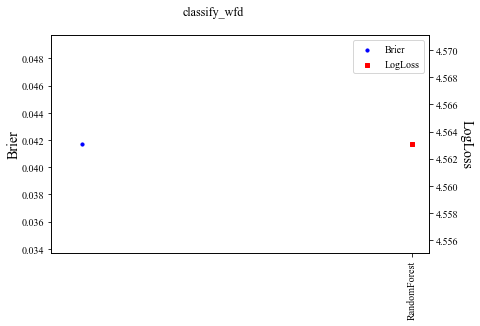

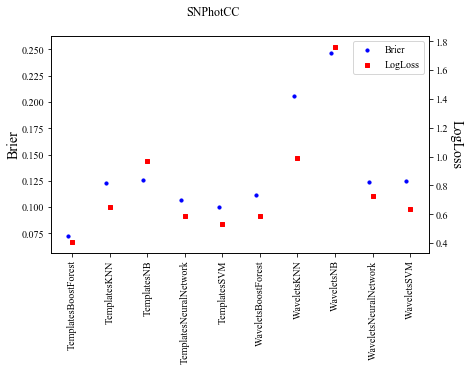

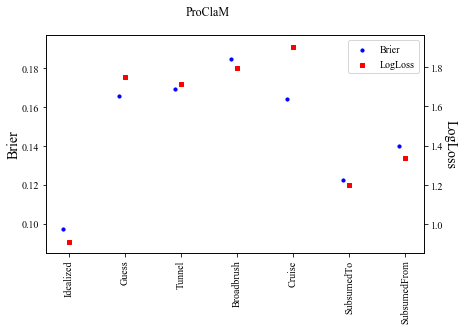

In [14]:
for dataset in [mystery, snphotcc, plasticc]:
    start = timeit.timeit()
    data = np.empty((len(metricslist), len(dataset['names'])))
    for cc, pair in enumerate(dataset['class_pairs']):
        print(cc, pair)
        probm, truthv = read_class_pairs(pair, dataset, cc)
        print(np.shape(probm))
        print(enumerate(metricslist))
        #loc=dataset['dirname'], title=dataset['label']+' '+dataset['names'][cc])
        for count, metric in enumerate(metricslist):
            D = getattr(proclam.metrics, metric)()
            hm = D.evaluate(probm, truthv)
            data[count][cc] = hm
    dataset['results'] = data
    metric_plot(dataset, metricslist, markerlist, colors)
    end = timeit.timeit()
    elapsed = end-start
    print('took %s seconds' %elapsed)

In [15]:
# more_data = np.empty((len(metricslist), len(more_names)))
# for cc, pair in enumerate(more_class_pairs):
#     probm, truthv = read_class_pairs(pair, dirname)
#     for count, metric in enumerate(metricslist):
#         D = getattr(proclam.metrics, metric)()
#         hm = D.evaluate(probm, truthv)
#         more_data[count][cc] = hm

In [16]:
# metric_plot(more_names, metricslist, more_data, markerlist, colors, title='SNPhotCC', fileloc=dirname+'snphotccdata.png')

In [17]:
# data = np.empty((len(metricslist), len(names)))
# for cc, pair in enumerate(class_pairs):
#     probm, truthv = read_class_pairs(pair, dirname)
#     for count, metric in enumerate(metricslist):
#         D = getattr(proclam.metrics, metric)()
#         hm = D.evaluate(probm, truthv)
#         data[count][cc] = hm

In [18]:
# metric_plot(names, metricslist, data, markerlist, colors, title='Mystery Dataset', fileloc=dirname+'mysterydata.png')